In [2]:
%matplotlib inline
import os
import re

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/lfs1/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/lfs1/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (include \s+ '.*\.pro')
    '''


def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = os.path.join('/lfs1/home/jackyu/radiation',
                          'crd/LW/examples',
                          'separate_g_groups',
                          'study__lblnew_g1_threshold',
                          'h2o',
                          'band08_wn_1380_1900',
                          'ng_8',
                          'g_ascending_k_descending',
                          'refPTs_P_1_T_250__P_10_T_250__P_500_T_250',
                          'ng_refs_3__2__3',
                          'getabsth_auto__auto__auto',
                          'absth_dlogN_uniform__dlogN_uniform__dlogN_uniform',
                          'wgt_.55_.55_.85__.85_.85__0_.3_.55',
                          'wgt_flux_2',
                          'wgt_k_1',
                          'crd_a140ac7',
                          'atmpro_trp')
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [6]:
crdx_wgt = analysis.model('wgt')
crdx_wgt.type_model = 'crd'
crdx_wgt.rundir = os.path.join('/lfs1/home/jackyu/radiation',
                          'crd/LW/examples',
                          'separate_g_groups',
                          'study__lblnew_g1_threshold',
                          'h2o',
                          'band08_wn_1380_1900',
                          'ng_8',
                          'g_ascending_k_descending',
                          'refPTs_P_1_T_250__P_10_T_250__P_500_T_250',
                          'ng_refs_3__2__3',
                          'getabsth_auto__auto__auto',
                          'absth_dlogN_uniform__dlogN_uniform__dlogN_uniform',
                          'wgt_.55_.55_.85__.85_.85__0_.3_.55',
                          'wgt_flux_2',
                          'wgt_k_1',
                          'crd_a140ac7',
                          'atmpro_trp')
crdx_wgt.fpath_flux = 'output_xfluxg.dat'
crdx_wgt.fpath_coolr = 'output_xcoolrg.dat'
crdx_wgt.linestyle = '--'
crdx_wgt.load_data()

In [7]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [8]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [9]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [10]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [11]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, innames())))

vstar = 1380

nband = 520

nv = 200

dv = 0.005

tsfc = 300.0

ng = 8

nref = 3

p_refs = (/ 1,  10, 500 /)

t_refs = (/ 250, 250, 250 /)

ng_refs = (/ 3,   2,   3 /)

data wgt
     &     /.55, .55, .85,
     &     .85, .85,
     &     0, .3, .55/

option_wgt_flux = 2

option_wgt_k = 1

option_klin = 0

klin = 6.375563e-24

include 'trp75.pro'


In [12]:
fig.display_hrefanchor()

In [13]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [14]:
table_dgdgs.display_hrefanchor()

In [15]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [16]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [17]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

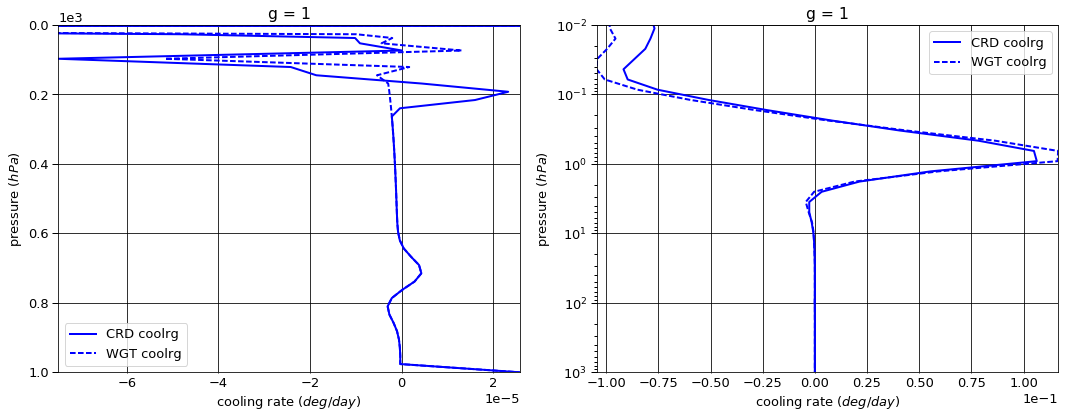

# Figure: cooling rate g-group 2

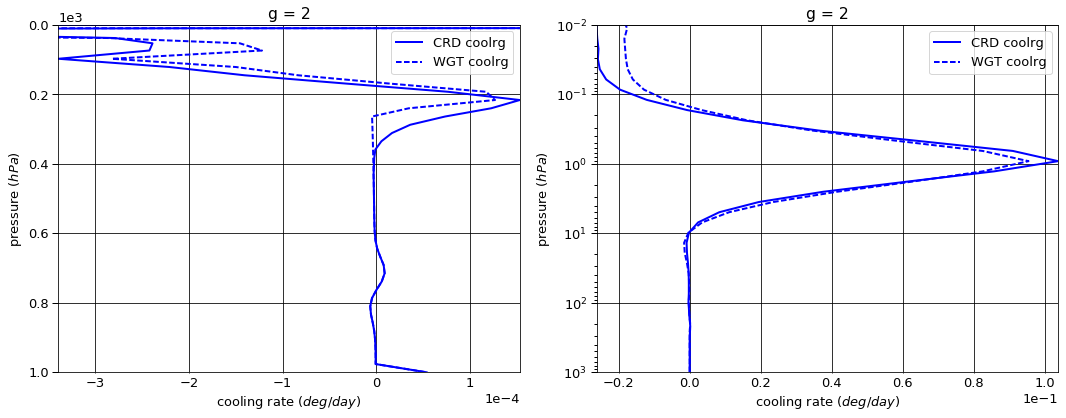

# Figure: cooling rate g-group 3

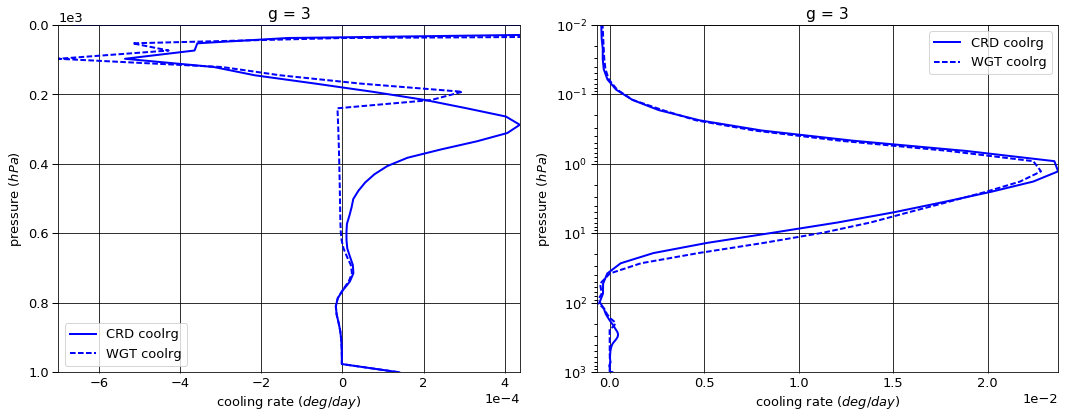

# Figure: cooling rate g-group 4

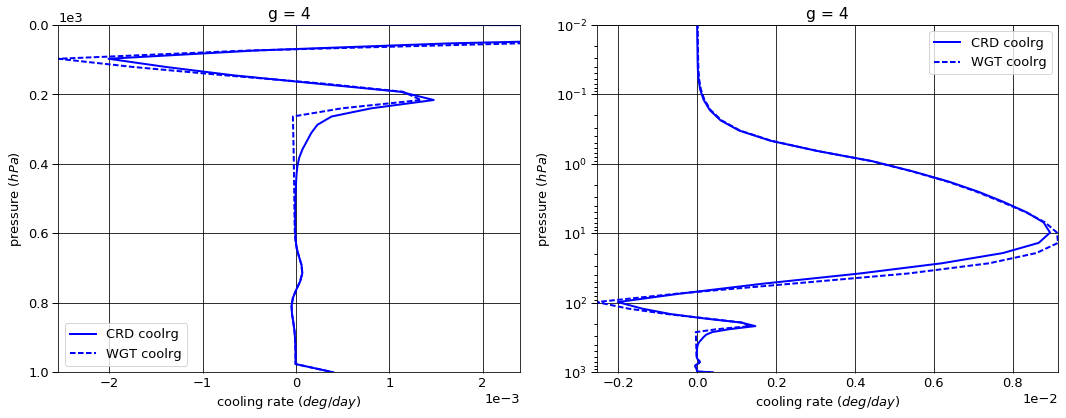

# Figure: cooling rate g-group 5

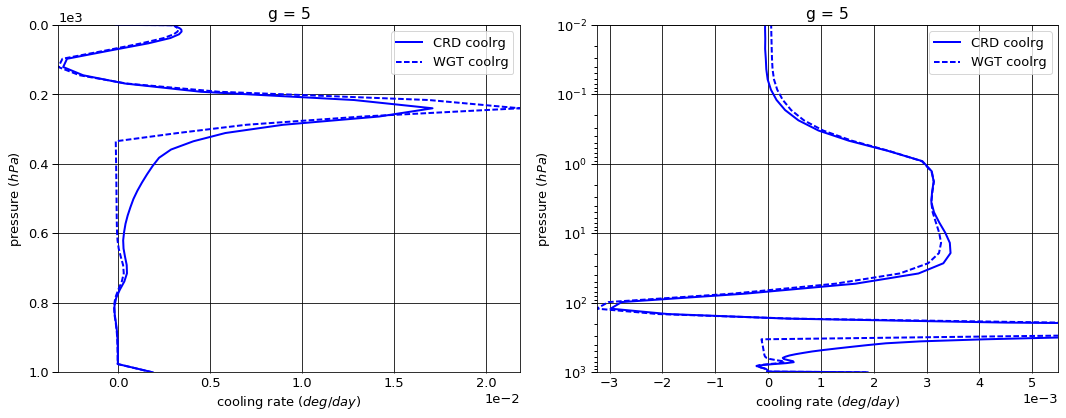

# Figure: cooling rate g-group 6

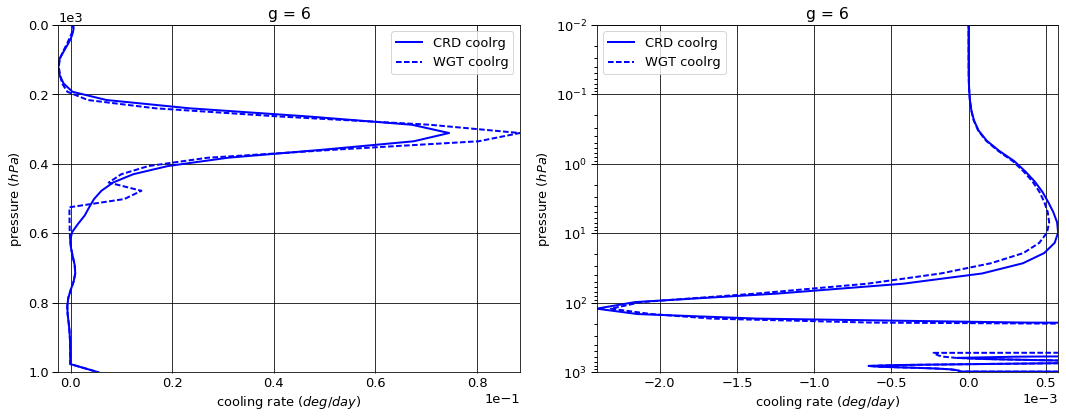

# Figure: cooling rate g-group 7

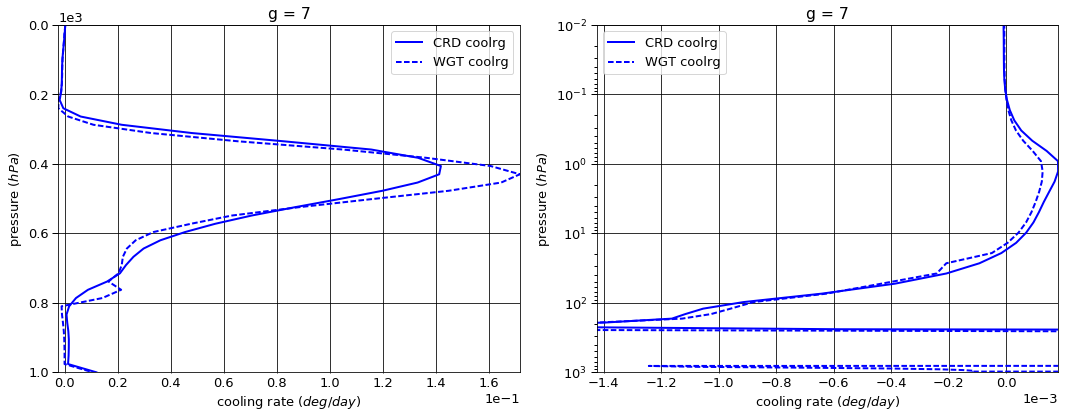

# Figure: cooling rate g-group 8

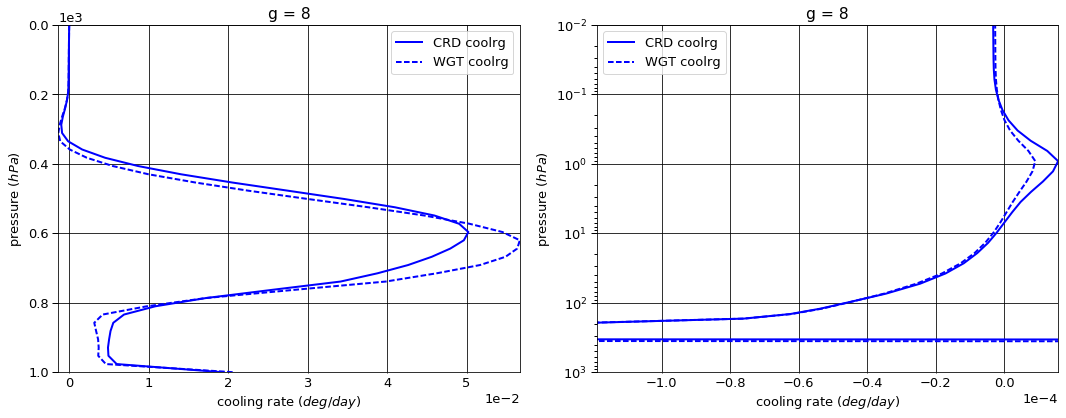

# Figure: cooling rate g-group total

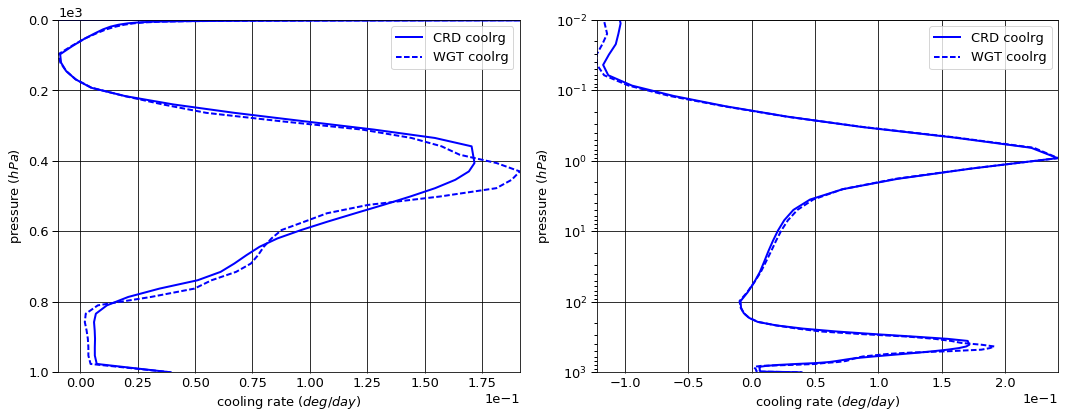

In [18]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [19]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg     fnetg
g pressure level                                
1 0.0      1      -0.009860   0.000000 -0.009860
  1013.0   76     -0.043086   0.043013 -0.000073
2 0.0      1      -0.021445   0.000000 -0.021445
  1013.0   76     -0.090246   0.090093 -0.000153
3 0.0      1      -0.027961   0.000000 -0.027961
  1013.0   76     -0.233319   0.232923 -0.000397
4 0.0      1      -0.040013   0.000000 -0.040013
  1013.0   76     -0.669480   0.668345 -0.001135
5 0.0      1      -0.242206   0.000000 -0.242206
  1013.0   76     -3.109608   3.104277 -0.005331
6 0.0      1      -1.208156   0.000000 -1.208156
  1013.0   76     -9.177424   9.161832 -0.015592
7 0.0      1      -4.209276   0.000000 -4.209276
  1013.0   76    -17.734956  17.702892 -0.032064
8 0.0      1      -1.934307   0.000000 -1.934307
  1013.0   76     -4.796914   4.733499 -0.063415


WGT


flug       fldg     fnetg
g pressure level                                
1 0.0      1      -0.010004   0.000000 -0.010004
  1013.0   76     -0.043086   0.043013 -0.000073
2 0.0      1      -0.022017   0.000000 -0.022017
  1013.0   76     -0.090246   0.090093 -0.000153
3 0.0      1      -0.026525   0.000000 -0.026525
  1013.0   76     -0.233319   0.232923 -0.000397
4 0.0      1      -0.037984   0.000000 -0.037984
  1013.0   76     -0.669480   0.668345 -0.001135
5 0.0      1      -0.192363   0.000000 -0.192363
  1013.0   76     -3.109608   3.104335 -0.005273
6 0.0      1      -1.232823   0.000000 -1.232823
  1013.0   76     -9.177424   9.161832 -0.015592
7 0.0      1      -4.260523   0.000000 -4.260523
  1013.0   76    -17.734956  17.705034 -0.029922
8 0.0      1      -1.963198   0.000000 -1.963198
  1013.0   76     -4.796914   4.737917 -0.058996


WGT - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.000144  0.000000 -0.000144
  1013.0   76     0.000000  0.000000  0.000000
2 0.0      1     -0.000572  0.000000 -0.000572
  1013.0   76     0.000000  0.000000  0.000000
3 0.0      1      0.001436  0.000000  0.001436
  1013.0   76     0.000000  0.000000  0.000000
4 0.0      1      0.002029  0.000000  0.002029
  1013.0   76     0.000000  0.000000  0.000000
5 0.0      1      0.049842  0.000000  0.049842
  1013.0   76     0.000000  0.000058  0.000059
6 0.0      1     -0.024666  0.000000 -0.024666
  1013.0   76     0.000000  0.000000  0.000000
7 0.0      1     -0.051247  0.000000 -0.051247
  1013.0   76     0.000000  0.002142  0.002142
8 0.0      1     -0.028892  0.000000 -0.028892
  1013.0   76     0.000000  0.004419  0.004419

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -9.143660e-02
  1001.112500 75     2.582176e-05
2 0.000312    1     -2.827525e-02
  1001.112500 75     5.388226e-05
3 0.000312    1     -6.326984e-04
  1001.112500 75     1.399492e-04
4 0.000312    1     -7.977073e-06
  1001.112500 75     4.005261e-04
5 0.000312    1     -8.507197e-05
  1001.112500 75     1.884461e-03
6 0.000312    1     -9.144778e-07
  1001.112500 75     5.502194e-03
7 0.000312    1     -9.942125e-06
  1001.112500 75     1.189969e-02
8 0.000312    1     -3.446216e-06
  1001.112500 75     1.944900e-02


WGT


coolrg
g pressure    layer              
1 0.000312    1     -1.106026e-01
  1001.112500 75     2.582176e-05
2 0.000312    1     -1.999216e-02
  1001.112500 75     5.388226e-05
3 0.000312    1     -5.503623e-04
  1001.112500 75     1.399492e-04
4 0.000312    1      4.449669e-06
  1001.112500 75     4.005261e-04
5 0.000312    1      2.987556e-05
  1001.112500 75     1.860771e-03
6 0.000312    1     -7.660450e-07
  1001.112500 75     5.502194e-03
7 0.000312    1     -7.309734e-06
  1001.112500 75     1.056077e-02
8 0.000312    1     -2.795411e-06
  1001.112500 75     2.085377e-02


WGT - CRD


coolrg
g pressure    layer              
1 0.000312    1     -1.916599e-02
  1001.112500 75     0.000000e+00
2 0.000312    1      8.283090e-03
  1001.112500 75     0.000000e+00
3 0.000312    1      8.233600e-05
  1001.112500 75     0.000000e+00
4 0.000312    1      1.242674e-05
  1001.112500 75     0.000000e+00
5 0.000312    1      1.149475e-04
  1001.112500 75    -2.368930e-05
6 0.000312    1      1.484328e-07
  1001.112500 75     0.000000e+00
7 0.000312    1      2.632391e-06
  1001.112500 75    -1.338920e-03
8 0.000312    1      6.508057e-07
  1001.112500 75     1.404771e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-7.693224,0.000000,-7.693224
1013.0,76,-35.855033,35.736874,-0.118159



WGT


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-7.745437,0.000000,-7.745437
1013.0,76,-35.855033,35.743493,-0.111540



WGT - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.052213,0.000000,-0.052213
1013.0,76,0.000000,0.006619,0.006619


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.120452
1001.112500,75,0.039356



WGT


,,coolrg
pressure,layer,
0.000312,1,-0.131122
1001.112500,75,0.039398



WGT - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.010670
1001.112500,75,0.000042


In [20]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.001154,0.001196
2,0.002433,0.002525
3,0.006375,0.006475
4,0.017817,0.018636
5,0.083269,0.086563
6,0.248308,0.254744
7,0.479058,0.498801
8,0.161587,0.131059


In [21]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,4.262964e-18
2,2.786366e-19
3,1.821229e-20
4,1.179072e-20
5,7.724450e-22
6,2.503686e-21
7,1.649401e-22
8,1.086608e-23


In [22]:
def spreadsheet():
    ng = crd.data['dgdgs'].dims['g']
    ng_refs = [3, 2, 3]
    p_refs = [1, 10, 500]
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [23]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet())

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,4.262964e-18,NaN,0.001154,0.001196,0.001154,0.001196,1.0
2,2.786366e-19,0.065362,0.002433,0.002525,0.003587,0.003721,1.0
3,1.821229e-20,0.065362,0.006375,0.006475,0.009962,0.010196,1.0
4,1.179072e-20,0.647404,0.017817,0.018636,0.027779,0.028832,10.0
5,7.724450e-22,0.065513,0.083269,0.086563,0.111048,0.115395,10.0
6,2.503686e-21,3.241249,0.248308,0.254744,0.359356,0.370140,500.0
7,1.649401e-22,0.065879,0.479058,0.498801,0.838413,0.868941,500.0
8,1.086608e-23,0.065879,0.161587,0.131059,1.000000,1.000000,500.0


In [24]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [25]:
pd.set_option('display.max_rows', None)
display.display(
    pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1],
                sep=r'\s+')
    )
pd.reset_option('display.max_rows')

pressure       absmean    absmeanlog      ratio
layer g                                                    
1     1     0.000312  1.544117e-17  8.163471e-18   1.891496
      2     0.000312  9.080355e-19  4.282497e-19   2.120341
      3     0.000312  2.352266e-20  1.033905e-20   2.275127
      4     0.000312  3.357512e-22  2.455329e-22   1.367439
      5     0.000312  2.352725e-22  6.676095e-23   3.524103
      6     0.000312  1.234785e-24  1.188385e-24   1.039044
      7     0.000312  2.615952e-24  1.297761e-24   2.015742
      8     0.000312  1.836956e-24  1.972295e-25   9.313795
2     1     0.000750  1.544086e-17  8.173163e-18   1.889215
      2     0.000750  9.110582e-19  4.296683e-19   2.120376
      3     0.000750  2.364690e-20  1.039178e-20   2.275539
      4     0.000750  3.392339e-22  2.486121e-22   1.364511
      5     0.000750  2.359229e-22  6.703684e-23   3.519302
      6     0.000750  1.249773e-24  1.203097e-24   1.038797
      7     0.000750  2.625448e-24  1.302906e-24   2.015071
      8     0.000750  1.839335e-24  1.978624e-25   9.296031
3     1     0.001052  1.544031e-17  8.192696e-18   1.884643
      2     0.001052  9.171502e-19  4.324915e-19   2.120620
      3     0.001052  2.388494e-20  1.048026e-20   2.279040
      4     0.001052  3.438539e-22  2.524571e-22   1.362029
      5     0.001052  2.371007e-22  6.743312e-23   3.516087
      6     0.001052  1.268203e-24  1.220987e-24   1.038670
      7     0.001052  2.643565e-24  1.312146e-24   2.014688
      8     0.001052  1.844097e-24  1.990278e-25   9.265525
4     1     0.001476  1.543952e-17  8.212373e-18   1.880032
      2     0.001476  9.233516e-19  4.353738e-19   2.120825
      3     0.001476  2.413217e-20  1.057525e-20   2.281949
      4     0.001476  3.490889e-22  2.569036e-22   1.358832
      5     0.001476  2.383427e-22  6.786897e-23   3.511807
      6     0.001476  1.289518e-24  1.241748e-24   1.038470
      7     0.001476  2.662437e-24  1.321874e-24   2.014139
      8     0.001476  1.849059e-24  2.002394e-25   9.234237
5     1     0.002070  1.543850e-17  8.231924e-18   1.875442
      2     0.002070  9.295827e-19  4.382820e-19   2.120970
      3     0.002070  2.438678e-20  1.067733e-20   2.283977
      4     0.002070  3.551014e-22  2.621267e-22   1.354694
      5     0.002070  2.396470e-22  6.835409e-23   3.505964
      6     0.002070  1.314575e-24  1.266240e-24   1.038172
      7     0.002070  2.681943e-24  1.332080e-24   2.013349
      8     0.002070  1.854169e-24  2.014918e-25   9.202206
6     1     0.002904  1.543721e-17  8.251343e-18   1.870873
      2     0.002904  9.358465e-19  4.412218e-19   2.121034
      3     0.002904  2.465057e-20  1.078865e-20   2.284862
      4     0.002904  3.621814e-22  2.684141e-22   1.349338
      5     0.002904  2.410315e-22  6.890772e-23   3.497889
      6     0.002904  1.344801e-24  1.295892e-24   1.037742
      7     0.002904  2.702236e-24  1.342914e-24   2.012219
      8     0.002904  1.859446e-24  2.027986e-25   9.168928
7     1     0.004074  1.543563e-17  8.270626e-18   1.866320
      2     0.004074  9.421491e-19  4.442025e-19   2.120990
      3     0.004074  2.492608e-20  1.091273e-20   2.284128
      4     0.004074  3.707367e-22  2.761775e-22   1.342385
      5     0.004074  2.425217e-22  6.955689e-23   3.486667
      6     0.004074  1.382204e-24  1.332709e-24   1.037138
      7     0.004074  2.723537e-24  1.354588e-24   2.010601
      8     0.004074  1.864913e-24  2.041800e-25   9.133674
8     1     0.005714  1.543371e-17  8.289784e-18   1.861775
      2     0.005714  9.485037e-19  4.472393e-19   2.120797
      3     0.005714  2.521708e-20  1.105463e-20   2.281133
      4     0.005714  3.813413e-22  2.859937e-22   1.333391
      5     0.005714  2.441540e-22  7.033995e-23   3.471057
      6     0.005714  1.429608e-24  1.379515e-24   1.036312
      7     0.005714  2.746165e-24  1.367412e-24   2.008294
      8     0.005714  1.870609e-24  2.056652e-25   9.095410
9     1     0.008015  1.543138e-17  8.308809e-18   1

# Histogram of wavenumbers in g-group 1

In [26]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
